This block of codes Processed the Ecosystem Service Valuation (ESV) data & Perform Annual to Monthly Interpolation. Compute the statistical comparison for the three interpolation methods. Then Use the best method to estimate the monthly data, then compute correlation analysis between the Variables (KNDVI+Precipitation+ESV), for each continent and  the correlation for specific biomes.

@ Author: Pius Nwachukwu

In [ ]:
!pip install eemont
!pip install wxee
!pip install earthengine-api

In [ ]:
import ee, eemont, wxee, pandas as pd


In [ ]:
# Authenticate and initialize the Earth Engine module.
ee.Authenticate()
ee.Initialize(project='ee-')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 2nd Phase: Step 1. Process the dats & Perform Annual to Monthly Interpolation

In [ ]:
# Complete Code of the 3 Methods of Estimation

import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline

# Load the ESV dataset
esv_file_path = "/content/drive/My Drive/ESV_Data/Esvd_Full_Data_Version_MAY2023V1.1.csv"
esv_df = pd.read_csv(esv_file_path)

# Keep only necessary columns
esv_df = esv_df[['Continent', 'ESVD2.0_Biome', 'Year_Pub', 'Int$ Per Hectare Per Year']]

# Rename Year column for consistency
esv_df.rename(columns={'Year_Pub': 'year'}, inplace=True)

# Ensure year is numeric
esv_df['year'] = pd.to_numeric(esv_df['year'], errors='coerce')

# Filter for records from 2000 onwards
esv_df = esv_df[esv_df['year'] >= 2000]

# Handle missing values using forward and backward fill within each Continent & Biome group
esv_df['Int$ Per Hectare Per Year'] = esv_df.groupby(['Continent', 'ESVD2.0_Biome'])['Int$ Per Hectare Per Year'].ffill()
esv_df['Int$ Per Hectare Per Year'] = esv_df.groupby(['Continent', 'ESVD2.0_Biome'])['Int$ Per Hectare Per Year'].bfill()

# Fill any remaining NaNs with the median value for each Continent
esv_df['Int$ Per Hectare Per Year'] = esv_df.groupby('Continent')['Int$ Per Hectare Per Year'].transform(lambda x: x.fillna(x.median()))

# Aggregate duplicate years by computing the mean ESV value
esv_df = esv_df.groupby(['Continent', 'ESVD2.0_Biome', 'year'], as_index=False).agg({
    'Int$ Per Hectare Per Year': 'mean'
})

# Function to generate monthly ESV estimates using linear interpolation
def create_monthly_esv_linear(df):
    monthly_records = []
    for _, row in df.iterrows():
        for month in range(1, 13):  # Create 12 months per year
            monthly_records.append({
                'Continent': row['Continent'],
                'year': row['year'],
                'month': month,
                'ESVD2.0_Biome': row['ESVD2.0_Biome'],
                'Int$ Per Hectare Per Year': row['Int$ Per Hectare Per Year'] / 12  # Evenly distribute
            })
    return pd.DataFrame(monthly_records)

# Generate monthly estimates using linear interpolation
esv_monthly_linear = create_monthly_esv_linear(esv_df)

# Function to generate monthly ESV estimates using spline interpolation
def create_monthly_esv_spline(df):
    monthly_records = []
    grouped = df.groupby(['Continent', 'ESVD2.0_Biome'])

    for (continent, biome), group in grouped:
        group = group.sort_values(by='year')  # Ensure years are increasing
        years = group['year'].values
        esv_values = group['Int$ Per Hectare Per Year'].values

        if len(years) < 2:
            continue  # Skip if there's only one year of data

        spline = CubicSpline(years, esv_values, bc_type='natural')

        for year in range(years.min(), years.max() + 1):
            for month in range(1, 13):
                monthly_esv = spline(year) / 12  # Distribute yearly estimate over 12 months
                monthly_records.append({
                    'Continent': continent,
                    'year': year,
                    'month': month,
                    'ESVD2.0_Biome': biome,
                    'Int$ Per Hectare Per Year': monthly_esv
                })

    return pd.DataFrame(monthly_records)

# Generate monthly estimates using spline interpolation
esv_monthly_spline = create_monthly_esv_spline(esv_df)

# Function to generate monthly ESV estimates using rolling mean
def create_monthly_esv_rolling(df, window=3):
    monthly_records = []
    grouped = df.groupby(['Continent', 'ESVD2.0_Biome'])

    for (continent, biome), group in grouped:
        group = group.sort_values(by='year')
        group['Rolling_ESV'] = group['Int$ Per Hectare Per Year'].rolling(window=window, min_periods=1, center=True).mean()

        for _, row in group.iterrows():
            for month in range(1, 13):
                monthly_records.append({
                    'Continent': row['Continent'],
                    'year': row['year'],
                    'month': month,
                    'ESVD2.0_Biome': row['ESVD2.0_Biome'],
                    'Int$ Per Hectare Per Year': row['Rolling_ESV'] / 12  # Distribute yearly estimate over 12 months
                })

    return pd.DataFrame(monthly_records)

# Generate monthly estimates using rolling mean
esv_monthly_rolling = create_monthly_esv_rolling(esv_df)

# Display first few rows of each method
esv_monthly_linear.head(), esv_monthly_spline.head(), esv_monthly_rolling.head()


In [ ]:
# # Save the Monthly Estimates
# import pandas as pd

# # Define file paths for saving the datasets
# linear_interpolation_path = "/content/drive/My Drive/ESV_Data/esv_monthly_linear.csv"
# spline_interpolation_path = "/content/drive/My Drive/ESV_Data/esv_monthly_spline.csv"
# rolling_mean_path = "/content/drive/My Drive/ESV_Data/esv_monthly_rolling.csv"

# # Save the datasets to CSV files
# esv_monthly_linear.to_csv(linear_interpolation_path, index=False)
# esv_monthly_spline.to_csv(spline_interpolation_path, index=False)
# esv_monthly_rolling.to_csv(rolling_mean_path, index=False)

# # Provide download links
# linear_interpolation_path, spline_interpolation_path, rolling_mean_path


In [ ]:
# Get the statistics

# !pip install ace-tools # Install ace-tools
# !pip install --upgrade xgboost
# !pip install --upgrade scikit-learn

import pandas as pd

# Load the saved datasets
linear_df = pd.read_csv("/content/drive/My Drive/ESV_Data/esv_monthly_linear.csv")
spline_df = pd.read_csv("/content/drive/My Drive/ESV_Data/esv_monthly_spline.csv")
rolling_df = pd.read_csv("/content/drive/My Drive/ESV_Data/esv_monthly_rolling.csv")

# Perform statistical analysis
linear_stats = linear_df["Int$ Per Hectare Per Year"].describe()
spline_stats = spline_df["Int$ Per Hectare Per Year"].describe()
rolling_stats = rolling_df["Int$ Per Hectare Per Year"].describe()

# Combine results into a single dataframe for comparison
stats_comparison = pd.DataFrame({
    "Linear Interpolation": linear_stats,
    "Spline Interpolation": spline_stats,
    "Rolling Mean": rolling_stats
})

# Display the results
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Statistical Analysis of Monthly ESV Estimates", dataframe=stats_comparison)

print("Statistical Analysis of Monthly ESV Estimates:")
print(stats_comparison)


Statistical Analysis of Monthly ESV Estimates:
       Linear Interpolation  Spline Interpolation  Rolling Mean
count           2832.000000           4200.000000   2832.000000
mean             395.434030            241.932974    381.637395
std             2410.419216           1577.252968   1877.237074
min                0.000142           -514.861107      0.004723
25%                2.819805              3.423533      7.127671
50%               17.841727             34.227990     28.868600
75%               72.538347            106.050229     91.569536
max            22644.726761          22042.198322  22644.726761


# Step 2. Compute the statistical comparison for the three interpolation methods
Based on the following metrics:
    Mean Absolute Error (MAE) – Measures the average absolute difference between estimated and original values.
    Root Mean Square Error (RMSE) – Penalizes larger errors more than MAE.
    Pearson Correlation – Measures the linear relationship between interpolated and original ESV values.
    Spearman Correlation – Measures monotonic relationships (useful if data is not normally distributed).
    Standard Deviation (STD) – Checks if the variability in estimated monthly values matches the original yearly data.

In [ ]:
# Step 2: Compute Statistical Comparison for the Three Interpolation Methods
# Now, we compare the mean, median, standard deviation, and range of the three methods.

# Compute summary statistics for each method
linear_stats = esv_monthly_linear['Int$ Per Hectare Per Year'].describe()
spline_stats = esv_monthly_spline['Int$ Per Hectare Per Year'].describe()
rolling_stats = esv_monthly_rolling['Int$ Per Hectare Per Year'].describe()

# Combine into a single DataFrame
stats_comparison = pd.DataFrame({
    'Linear Interpolation': linear_stats,
    'Spline Interpolation': spline_stats,
    'Rolling Mean': rolling_stats
})

# Display the statistical comparison
print(stats_comparison)



       Linear Interpolation  Spline Interpolation  Rolling Mean
count           2832.000000           4200.000000   2832.000000
mean             395.434030            241.932974    381.637395
std             2410.419216           1577.252968   1877.237074
min                0.000142           -514.861107      0.004723
25%                2.819805              3.423533      7.127671
50%               17.841727             34.227990     28.868600
75%               72.538347            106.050229     91.569536
max            22644.726761          22042.198322  22644.726761


In [ ]:
# Pearson's R (Comparison of the Monthly Estimation Methods)
import numpy as np
import pandas as pd
from scipy.stats import pearsonr  # Import Pearson correlation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to compute statistical metrics
def compute_statistics(true_annual, estimated_monthly, method_name):
    """
    Compute MAE, RMSE, Pearson Correlation, and STD for the estimated monthly ESV values.

    Parameters:
        true_annual (pd.DataFrame): The original annual ESV dataset.
        estimated_monthly (pd.DataFrame): The monthly estimated ESV dataset.
        method_name (str): Name of the interpolation method.

    Returns:
        dict: A dictionary with statistical metrics.
    """

    # Aggregate monthly estimates to annual for comparison
    estimated_annual = estimated_monthly.groupby(['Continent', 'year'])['Int$ Per Hectare Per Year'].sum().reset_index()

    # Merge with true annual data
    merged_df = pd.merge(true_annual, estimated_annual, on=['Continent', 'year'], suffixes=('_true', '_pred'))

    # Compute statistical metrics
    mae = mean_absolute_error(merged_df['Int$ Per Hectare Per Year_true'], merged_df['Int$ Per Hectare Per Year_pred'])
    rmse = np.sqrt(mean_squared_error(merged_df['Int$ Per Hectare Per Year_true'], merged_df['Int$ Per Hectare Per Year_pred']))
    pearson_corr, _ = pearsonr(merged_df['Int$ Per Hectare Per Year_true'], merged_df['Int$ Per Hectare Per Year_pred'])  # Using Pearson correlation
    std = np.std(merged_df['Int$ Per Hectare Per Year_pred'])

    # Return results as a dictionary
    return {
        "Method": method_name,
        "MAE": mae,
        "RMSE": rmse,
        "Pearson Correlation": pearson_corr,  # Use Pearson correlation
        "STD": std
    }

# Compute statistics for each method
linear_stats = compute_statistics(esv_df, esv_monthly_linear, "Linear Interpolation")
spline_stats = compute_statistics(esv_df, esv_monthly_spline, "Spline Interpolation")
rolling_stats = compute_statistics(esv_df, esv_monthly_rolling, "Rolling Mean")

# Combine results into a DataFrame for easy visualization
stats_df = pd.DataFrame([linear_stats, spline_stats, rolling_stats])

# Display the results
print(stats_df)


                 Method           MAE          RMSE  Pearson Correlation  \
0  Linear Interpolation  19955.794561  66548.328650             0.393928   
1  Spline Interpolation  18329.119684  59310.913014             0.269501   
2          Rolling Mean  19722.220445  58671.358228             0.353197   

            STD  
0  69045.387263  
1  58024.904846  
2  59390.823534  


# Step 3. Then Use the Best Mothod to Estimate the Monthly Data

In [ ]:

# Re-load necessary packages after execution state reset
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline

# Load the dataset
esv_file_path = "/content/drive/My Drive/ESV_Data/Esvd_Full_Data_Version_MAY2023V1.1.csv"
esv_df = pd.read_csv(esv_file_path)

# Rename the Year column for consistency
esv_df.rename(columns={'Year_Pub': 'year'}, inplace=True)

# Ensure year is numeric and filter data from 2000 onwards
esv_df['year'] = pd.to_numeric(esv_df['year'], errors='coerce')
esv_df = esv_df[esv_df['year'] >= 2000]

# Keep only relevant columns
esv_df = esv_df[['Continent', 'ESVD2.0_Biome', 'year', 'Int$ Per Hectare Per Year']]

# Fill missing values using the median for each Continent
esv_df['Int$ Per Hectare Per Year'] = esv_df.groupby('Continent')['Int$ Per Hectare Per Year'].transform(lambda x: x.fillna(x.median()))

# Function to expand annual data into monthly records
def create_monthly_esv(df):
    monthly_records = []
    for _, row in df.iterrows():
        for month in range(1, 13):  # Create 12 months per year
            monthly_records.append({
                'Continent': row['Continent'],
                'year': row['year'],
                'month': month,
                'ESVD2.0_Biome': row['ESVD2.0_Biome'],
                'Int$ Per Hectare Per Year': row['Int$ Per Hectare Per Year'] / 12,  # Evenly distribute across months
                'date': pd.to_datetime(f"{row['year']}-{month:02d}-01")  # YYYY-MM-01 format
            })
    return pd.DataFrame(monthly_records)

# Generate the monthly dataset
esv_monthly_df = create_monthly_esv(esv_df)

# Convert year and month to a datetime format
esv_monthly_df['date'] = pd.to_datetime(esv_monthly_df['year'].astype(str) + '-' + esv_monthly_df['month'].astype(str) + '-01')

# Display summary statistics
print("Summary Statistics:\n", esv_monthly_df.describe())

# Check if there are any missing values
print("Missing Values After Transformation:\n", esv_monthly_df.isnull().sum())

# Display first few rows to confirm transformation
print(esv_monthly_df.head())


Summary Statistics:
                year         month  Int$ Per Hectare Per Year  \
count  32448.000000  32448.000000               32448.000000   
mean    2014.372781      6.500000                 684.742780   
min     2000.000000      1.000000                   0.000000   
25%     2011.000000      3.750000                   1.675221   
50%     2016.000000      6.500000                   5.498800   
75%     2019.000000      9.250000                  26.845838   
max     2022.000000     12.000000              165725.675658   
std        5.914553      3.452106                5829.901081   

                                date  
count                          32448  
mean   2014-10-30 17:22:16.686390528  
min              2000-01-01 00:00:00  
25%              2011-04-01 00:00:00  
50%              2016-07-01 00:00:00  
75%              2019-07-01 00:00:00  
max              2022-12-01 00:00:00  
std                              NaN  
Missing Values After Transformation:
 Continent    

In [ ]:
# Exporting the ESV Monthly conversion
# esv_monthly_df
# esv_monthly_df.to_csv('/content/drive/My Drive/ESV_Data/Filtered_ESV.csv', index=False)



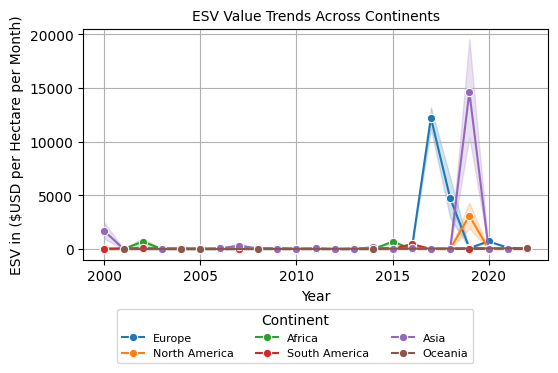

In [ ]:
# Visualize ESV Trends Across Continents

import matplotlib.pyplot as plt
import seaborn as sns

# Filter out the "Global" category
continent_filtered = esv_monthly_df[esv_monthly_df["Continent"] != "Global"]

# Plot ESV trends by continent over time
plt.figure(figsize=(6, 3))
sns.lineplot(data=continent_filtered, x='year', y='Int$ Per Hectare Per Year', hue='Continent', marker='o')

# Modify labels and title
plt.title('ESV Value Trends Across Continents', fontsize=10)
plt.xlabel('Year')
plt.ylabel('ESV in ($USD per Hectare per Month)')

# Update legend to exclude "Global"
plt.legend(title='Continent', loc='upper right', bbox_to_anchor=(0.85, -0.19), ncol=3, fontsize=8)
plt.grid()

# Show the plot
plt.show()


# Step 4. Correlation Analysis between the Variables (KNDVI+Precip+ESV)


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt



In [ ]:
# # Correlation (ESV+Precip+KNDVI) For the entire dataset WITH 95%CI.

# Import necessary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Load datasets
chirps_file = "/content/drive/My Drive/CHIRPS_exports/CHIRPS_Monthly_TimeSeries_Fixed.csv"
esv_file = "/content/drive/My Drive/ESV_Data/Filtered_ESV.csv"
kndvi_file = "/content/drive/My Drive/NDVI_Time_Series_With_Country_Continent25.csv"

chirps_df = pd.read_csv(chirps_file)
esv_df = pd.read_csv(esv_file)
kndvi_df = pd.read_csv(kndvi_file)

chirps_df

# Convert date columns to datetime format
chirps_df['date'] = pd.to_datetime(chirps_df['date'], format='%Y-%m').dt.to_period('M').astype(str)
esv_df['date'] = pd.to_datetime(esv_df['date']).dt.to_period('M').astype(str)
kndvi_df['date'] = pd.to_datetime(kndvi_df['date']).dt.to_period('M').astype(str)

# Convert relevant columns to numeric
chirps_df['mean'] = pd.to_numeric(chirps_df['mean'], errors='coerce')
esv_df.rename(columns={'Int$ Per Hectare Per Year': 'ESV_Value'}, inplace=True)
esv_df['ESV_Value'] = pd.to_numeric(esv_df['ESV_Value'], errors='coerce')
kndvi_df.rename(columns={'mean': 'KNDVI_Value'}, inplace=True)
kndvi_df['KNDVI_Value'] = pd.to_numeric(kndvi_df['KNDVI_Value'], errors='coerce')

chirps_df.rename(columns={"mean": "mean_precip"}, inplace=True)

# Aggregate and merge datasets
final_agg_df = pd.merge(
    chirps_df.groupby(['Continent', 'date'], as_index=False)['mean_precip'].mean(),
    esv_df.groupby(['Continent', 'date'], as_index=False)['ESV_Value'].mean(),
    on=['Continent', 'date'], how='inner'
)

final_agg_df = pd.merge(
    final_agg_df,
    kndvi_df[['Continent', 'date', 'KNDVI_Value']],
    on=['Continent', 'date'], how='inner'
).groupby('date', as_index=False)[['mean_precip', 'ESV_Value', 'KNDVI_Value']].mean()

# Pearson Confidence Interval Function
def pearson_ci(x, y, confidence=0.95):
    r, p_value = stats.pearsonr(x, y)
    n = len(x)

    if n < 4:
        return r, p_value, None, None  # Not enough data for CI

    z = np.arctanh(r)  # Fisher transformation
    se = 1 / np.sqrt(n - 3)  # Standard error
    z_critical = stats.norm.ppf(1 - (1 - confidence) / 2)  # Critical z-score

    z_lower = z - z_critical * se
    z_upper = z + z_critical * se

    r_lower = np.tanh(z_lower)  # Convert back to correlation scale
    r_upper = np.tanh(z_upper)

    return r, p_value, r_lower, r_upper

# Spearman Confidence Interval Function (Bootstrapping)
def spearman_ci(x, y, num_samples=1000, confidence=0.95):
    boot_corrs = []
    n = len(x)

    if n < 4:
        return None, None  # Not enough data for CI

    for _ in range(num_samples):
        sample_idx = np.random.choice(range(n), size=n, replace=True)
        sample_corr, _ = stats.spearmanr(x.iloc[sample_idx], y.iloc[sample_idx])
        boot_corrs.append(sample_corr)

    lower_bound = np.percentile(boot_corrs, (1 - confidence) / 2 * 100)
    upper_bound = np.percentile(boot_corrs, (1 + confidence) / 2 * 100)

    return lower_bound, upper_bound

# Compute Pearson and Spearman Correlations with Confidence Intervals
correlation_results = {}

for x_col, y_col in [('mean_precip', 'ESV_Value'), ('KNDVI_Value', 'ESV_Value'), ('mean_precip', 'KNDVI_Value')]:
    r, p, r_low, r_high = pearson_ci(final_agg_df[x_col], final_agg_df[y_col])
    s_low, s_high = spearman_ci(final_agg_df[x_col], final_agg_df[y_col])

    correlation_results[f"Pearson {x_col} vs {y_col}"] = (r, p, r_low, r_high)
    correlation_results[f"Spearman {x_col} vs {y_col}"] = (s_low, s_high)

# Print correlation results with confidence intervals
print("\n=== Correlation Analysis Results ===")
for key, value in correlation_results.items():
    if "Pearson" in key:
        print(f"{key}: r={value[0]:.4f}, 95% CI: [{value[2]:.4f}, {value[3]:.4f}], p-value: {value[1]:.4e}")
    else:
        print(f"{key}: 95% CI: [{value[0]:.4f}, {value[1]:.4f}]")

# Return correlation results
correlation_results



=== Correlation Analysis Results ===
Pearson mean_precip vs ESV_Value: r=0.0040, 95% CI: [-0.1143, 0.1223], p-value: 9.4679e-01
Spearman mean_precip vs ESV_Value: 95% CI: [-0.0408, 0.1927]
Pearson KNDVI_Value vs ESV_Value: r=0.0294, 95% CI: [-0.0892, 0.1472], p-value: 6.2704e-01
Spearman KNDVI_Value vs ESV_Value: 95% CI: [-0.0254, 0.1879]
Pearson mean_precip vs KNDVI_Value: r=0.4641, 95% CI: [0.3659, 0.5521], p-value: 4.2719e-16
Spearman mean_precip vs KNDVI_Value: 95% CI: [0.3256, 0.5356]


{'Pearson mean_precip vs ESV_Value': (0.004043157989252859,
  0.946786254746321,
  -0.11429545700539061,
  0.12226863840185041),
 'Spearman mean_precip vs ESV_Value': (-0.040780913107711356,
  0.19265570741685806),
 'Pearson KNDVI_Value vs ESV_Value': (0.029428789285392085,
  0.6270355231446597,
  -0.0891655460938144,
  0.14720034596983989),
 'Spearman KNDVI_Value vs ESV_Value': (-0.02539092863503953,
  0.18792931206219726),
 'Pearson mean_precip vs KNDVI_Value': (0.46411402285668807,
  4.2718610601952083e-16,
  0.3659179550796286,
  0.5520897714075076),
 'Spearman mean_precip vs KNDVI_Value': (0.3255657338161647,
  0.5355607754882961)}

In [ ]:
# How to Generate More Cross-Correlation Plots:


# Compute cross-correlation for Precipitation vs ESV
lags, cross_corr_precip_esv = cross_corr(final_agg_df['mean'], final_agg_df['ESV_Value'])

# Compute cross-correlation for Precipitation vs KNDVI
lags, cross_corr_precip_kndvi = cross_corr(final_agg_df['mean'], final_agg_df['KNDVI_Value'])

# Compute cross-correlation for KNDVI vs ESV
lags, cross_corr_kndvi_esv = cross_corr(final_agg_df['KNDVI_Value'], final_agg_df['ESV_Value'])

# Plot Cross-Correlation between Precipitation and ESV
plt.figure(figsize=(7,4))
plt.stem(lags, cross_corr_precip_esv)
plt.xlabel('Lag (Months)')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation between Aggregated Precipitation and ESV')
plt.grid(True)
plt.show()

# Plot Cross-Correlation between Precipitation and KNDVI
plt.figure(figsize=(7,4))
plt.stem(lags, cross_corr_precip_kndvi)
plt.xlabel('Lag (Months)')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation between Aggregated Precipitation and KNDVI')
plt.grid(True)
plt.show()

# Plot Cross-Correlation between KNDVI and ESV
plt.figure(figsize=(7,4))
plt.stem(lags, cross_corr_kndvi_esv)
plt.xlabel('Lag (Months)')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation between Aggregated KNDVI and ESV')
plt.grid(True)
plt.show()




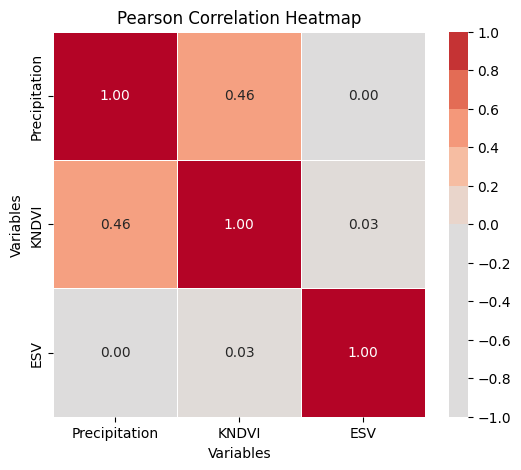

In [ ]:
# Pearson Correlation Heatmap Version 1
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Rename columns for better readability
renamed_df = final_agg_df.rename(columns={"mean_precip": "Precipitation",
                                         "KNDVI_Value": "KNDVI",
                                         "ESV_Value": "ESV"})

# Compute Pearson correlation matrix
pearson_corr_matrix = renamed_df[['Precipitation', 'KNDVI', 'ESV']].corr(method='pearson')

# Define discrete color bar ticks
discrete_levels = np.linspace(-1, 1, num=11)  # 11 levels for better readability

# Plot Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(pearson_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5,
            center=0, cbar_kws={"ticks": discrete_levels, "boundaries": discrete_levels})
            # Add 'boundaries' for discrete colorbar

# Formatting
plt.title("Pearson Correlation Heatmap")
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.show()

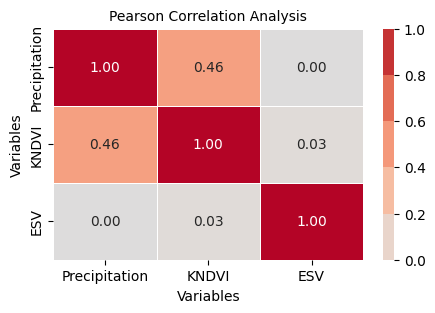

In [ ]:
# Pearson Correlation Heatmap Version 2
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Rename columns for better readability
renamed_df = final_agg_df.rename(columns={"mean": "Precipitation",
                                         "KNDVI_Value": "KNDVI",
                                         "ESV_Value": "ESV"})

# Compute Pearson correlation matrix
pearson_corr_matrix = renamed_df[['Precipitation', 'KNDVI', 'ESV']].corr(method='pearson')

# Define discrete color bar ticks and boundaries
discrete_levels = np.linspace(0, 1, num=6)  # 6 levels for better readability

# Plot Heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(pearson_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5,
            center=0, cbar_kws={"ticks": discrete_levels, "boundaries": discrete_levels, "spacing": 'proportional'})

# Formatting
plt.title("Pearson Correlation Analysis", fontsize=10)
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.show()

In [ ]:
# Correlation (ESV+Precip+KNDVI) For each continent EXLUDING Cross Correlation, but with 95%CI
# Import necessary libraries

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Load datasets
chirps_file = "/content/drive/My Drive/CHIRPS_exports/CHIRPS_Monthly_TimeSeries_Fixed.csv"
esv_file = "/content/drive/My Drive/ESV_Data/Filtered_ESV.csv"
kndvi_file = "/content/drive/My Drive/NDVI_Time_Series_With_Country_Continent25.csv"

chirps_df = pd.read_csv(chirps_file)
esv_df = pd.read_csv(esv_file)
kndvi_df = pd.read_csv(kndvi_file)

# Convert date columns to datetime format
chirps_df['date'] = pd.to_datetime(chirps_df['date'], format='%Y-%m').dt.to_period('M').astype(str)
esv_df['date'] = pd.to_datetime(esv_df['date']).dt.to_period('M').astype(str)
kndvi_df['date'] = pd.to_datetime(kndvi_df['date']).dt.to_period('M').astype(str)


# Convert relevant columns to numeric
chirps_df.rename(columns={"mean": "mean_precip"}, inplace=True)
chirps_df['mean_precip'] = pd.to_numeric(chirps_df['mean_precip'], errors='coerce')
esv_df.rename(columns={'Int$ Per Hectare Per Year': 'ESV_Value'}, inplace=True)
esv_df['ESV_Value'] = pd.to_numeric(esv_df['ESV_Value'], errors='coerce')
kndvi_df.rename(columns={'mean': 'KNDVI_Value'}, inplace=True)
kndvi_df['KNDVI_Value'] = pd.to_numeric(kndvi_df['KNDVI_Value'], errors='coerce')



# Get unique continents
continents = chirps_df['Continent'].unique()

# Function to compute Pearson confidence intervals
def pearson_ci(x, y, confidence=0.95):
    r, p_value = stats.pearsonr(x, y)
    n = len(x)

    if n < 4:
        return r, p_value, None, None  # Not enough data for CI

    z = np.arctanh(r)  # Fisher transformation
    se = 1 / np.sqrt(n - 3)  # Standard error
    z_critical = stats.norm.ppf(1 - (1 - confidence) / 2)  # Critical z-score

    z_lower = z - z_critical * se
    z_upper = z + z_critical * se

    r_lower = np.tanh(z_lower)  # Convert back to correlation scale
    r_upper = np.tanh(z_upper)

    return r, p_value, r_lower, r_upper

# Function to compute Spearman confidence intervals via bootstrapping
def spearman_ci(x, y, num_samples=1000, confidence=0.95):
    boot_corrs = []
    n = len(x)

    if n < 4:
        return None, None  # Not enough data for CI

    for _ in range(num_samples):
        sample_idx = np.random.choice(range(n), size=n, replace=True)
        sample_corr, _ = stats.spearmanr(x.iloc[sample_idx], y.iloc[sample_idx])
        boot_corrs.append(sample_corr)

    lower_bound = np.percentile(boot_corrs, (1 - confidence) / 2 * 100)
    upper_bound = np.percentile(boot_corrs, (1 + confidence) / 2 * 100)

    return lower_bound, upper_bound

# Initialize a dictionary to store results for each continent
continent_results = {}

# Loop through each continent to perform separate analysis
for continent in continents:
    print(f"\nProcessing: {continent}")

    # Filter datasets for the current continent
    chirps_filtered = chirps_df[chirps_df['Continent'] == continent]
    esv_filtered = esv_df[esv_df['Continent'] == continent]
    kndvi_filtered = kndvi_df[kndvi_df['Continent'] == continent]

    # Aggregate and merge datasets
    continent_agg_df = pd.merge(
        chirps_filtered.groupby(['date'], as_index=False)['mean_precip'].mean(),
        esv_filtered.groupby(['date'], as_index=False)['ESV_Value'].mean(),
        on=['date'], how='inner'
    )

    continent_agg_df = pd.merge(
        continent_agg_df,
        kndvi_filtered.groupby(['date'], as_index=False)['KNDVI_Value'].mean(),
        on=['date'], how='inner'
    )

    # Drop missing values before computing correlation
    continent_agg_df.dropna(inplace=True)

    # Convert date back to datetime format for proper plotting
    continent_agg_df['date'] = pd.to_datetime(continent_agg_df['date'])

    # Compute Pearson correlation with confidence intervals
    r_precip_esv, p_precip_esv, ci_lower_precip_esv, ci_upper_precip_esv = pearson_ci(continent_agg_df['mean_precip'], continent_agg_df['ESV_Value'])
    r_kndvi_esv, p_kndvi_esv, ci_lower_kndvi_esv, ci_upper_kndvi_esv = pearson_ci(continent_agg_df['KNDVI_Value'], continent_agg_df['ESV_Value'])

    # Compute Spearman correlation with confidence intervals
    spearman_lower_precip_esv, spearman_upper_precip_esv = spearman_ci(continent_agg_df['mean_precip'], continent_agg_df['ESV_Value'])
    spearman_lower_kndvi_esv, spearman_upper_kndvi_esv = spearman_ci(continent_agg_df['KNDVI_Value'], continent_agg_df['ESV_Value'])

    # Store results in dictionary
    continent_results[continent] = {
        "Pearson Precip vs. ESV": (r_precip_esv, p_precip_esv, ci_lower_precip_esv, ci_upper_precip_esv),
        "Pearson KNDVI vs. ESV": (r_kndvi_esv, p_kndvi_esv, ci_lower_kndvi_esv, ci_upper_kndvi_esv),
        "Spearman Precip vs. ESV": (spearman_lower_precip_esv, spearman_upper_precip_esv),
        "Spearman KNDVI vs. ESV": (spearman_lower_kndvi_esv, spearman_upper_kndvi_esv),
    }

    # Print correlation results with confidence intervals
    print(f"=== Correlation Analysis Results for {continent} ===")
    print(f"Pearson (Precip vs. ESV): r={r_precip_esv:.3f}, 95% CI: [{ci_lower_precip_esv:.3f}, {ci_upper_precip_esv:.3f}], p-value: {p_precip_esv:.3f}")
    print(f"Pearson (KNDVI vs. ESV): r={r_kndvi_esv:.3f}, 95% CI: [{ci_lower_kndvi_esv:.3f}, {ci_upper_kndvi_esv:.3f}], p-value: {p_kndvi_esv:.3f}")
    print(f"Spearman (Precip vs. ESV): 95% CI: [{spearman_lower_precip_esv:.3f}, {spearman_upper_precip_esv:.3f}]")
    print(f"Spearman (KNDVI vs. ESV): 95% CI: [{spearman_lower_kndvi_esv:.3f}, {spearman_upper_kndvi_esv:.3f}]")

# Return final results for all continents
continent_results



Processing: Europe
=== Correlation Analysis Results for Europe ===
Pearson (Precip vs. ESV): r=-0.048, 95% CI: [-0.171, 0.076], p-value: 0.448
Pearson (KNDVI vs. ESV): r=0.046, 95% CI: [-0.079, 0.168], p-value: 0.472
Spearman (Precip vs. ESV): 95% CI: [-0.158, 0.083]
Spearman (KNDVI vs. ESV): 95% CI: [-0.099, 0.143]

Processing: North America
=== Correlation Analysis Results for North America ===
Pearson (Precip vs. ESV): r=-0.050, 95% CI: [-0.200, 0.103], p-value: 0.524
Pearson (KNDVI vs. ESV): r=-0.056, 95% CI: [-0.206, 0.097], p-value: 0.475
Spearman (Precip vs. ESV): 95% CI: [-0.151, 0.140]
Spearman (KNDVI vs. ESV): 95% CI: [-0.181, 0.131]

Processing: Africa
=== Correlation Analysis Results for Africa ===
Pearson (Precip vs. ESV): r=-0.005, 95% CI: [-0.139, 0.129], p-value: 0.941
Pearson (KNDVI vs. ESV): r=-0.083, 95% CI: [-0.215, 0.051], p-value: 0.223
Spearman (Precip vs. ESV): 95% CI: [0.000, 0.259]
Spearman (KNDVI vs. ESV): 95% CI: [-0.084, 0.187]

Processing: South America
=

{'Europe': {'Pearson Precip vs. ESV': (-0.04813022825728956,
   0.4477567664283506,
   -0.17093076278369634,
   0.07614272732705524),
  'Pearson KNDVI vs. ESV': (0.04562394196814683,
   0.4717799243123409,
   -0.07863948902797349,
   0.16849130161844494),
  'Spearman Precip vs. ESV': (-0.15789365625964644, 0.08316076895818598),
  'Spearman KNDVI vs. ESV': (-0.09911602403659522, 0.14327979681640704)},
 'North America': {'Pearson Precip vs. ESV': (-0.04968277774016862,
   0.5237246055130707,
   -0.20003709150520216,
   0.10295763280155901),
  'Pearson KNDVI vs. ESV': (-0.0556343210335303,
   0.47516090031675157,
   -0.20575948916926032,
   0.09704922584586959),
  'Spearman Precip vs. ESV': (-0.15066882805310655, 0.14036154518855146),
  'Spearman KNDVI vs. ESV': (-0.18116550427402553, 0.13089781618863225)},
 'Africa': {'Pearson Precip vs. ESV': (-0.005079662142147169,
   0.940971599325407,
   -0.1387890059424707,
   0.12881156373506697),
  'Pearson KNDVI vs. ESV': (-0.08342701709464238,
 

# Step 5. Correlation for Specific Biome
i. Precipitation

In [ ]:
# Check unique biomes in the ESV dataset
unique_biomes = esv_df['ESVD2.0_Biome'].unique()

# Display the number of unique biomes and their names
num_biomes = len(unique_biomes)
unique_biomes, num_biomes



Processing: Tropical and subtropical forests


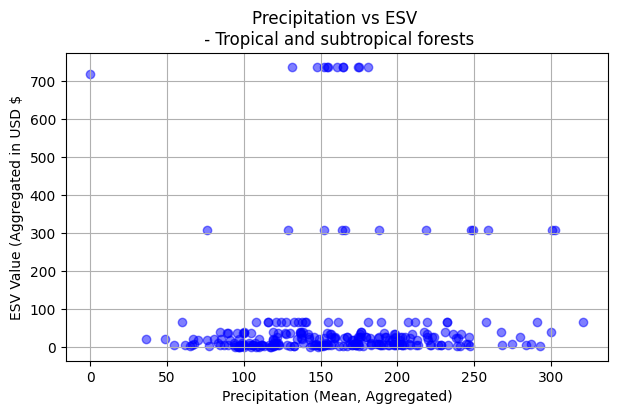

=== Correlation Analysis Results for Tropical and subtropical forests ===
Pearson Correlation: r=0.0292, 95% CI: [-0.0892, 0.1468], p-value: 6.2921e-01
Spearman Correlation: 95% CI: [0.0406, 0.2708]

Processing: Temperate forests and woodlands


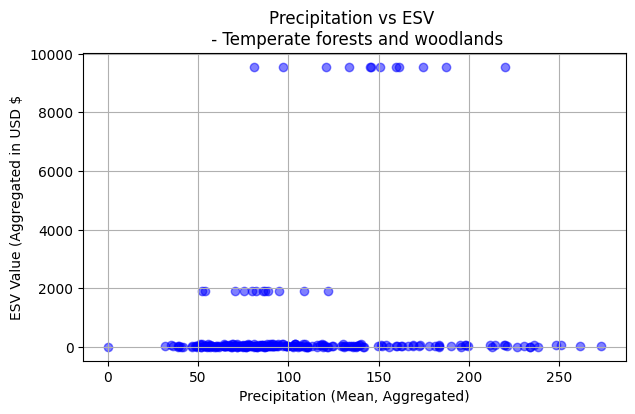

=== Correlation Analysis Results for Temperate forests and woodlands ===
Pearson Correlation: r=0.1657, 95% CI: [0.0430, 0.2834], p-value: 8.4121e-03
Spearman Correlation: 95% CI: [0.0122, 0.2690]

Processing: Intensive land use


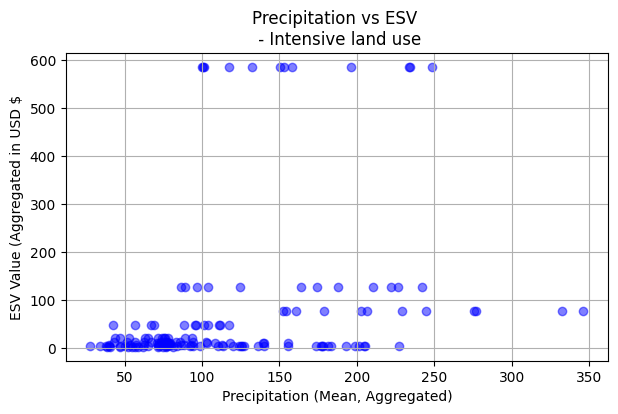

=== Correlation Analysis Results for Intensive land use ===
Pearson Correlation: r=0.3066, 95% CI: [0.1506, 0.4477], p-value: 1.8575e-04
Spearman Correlation: 95% CI: [0.2085, 0.5124]

Processing: Shrublands and shrubby woodlands


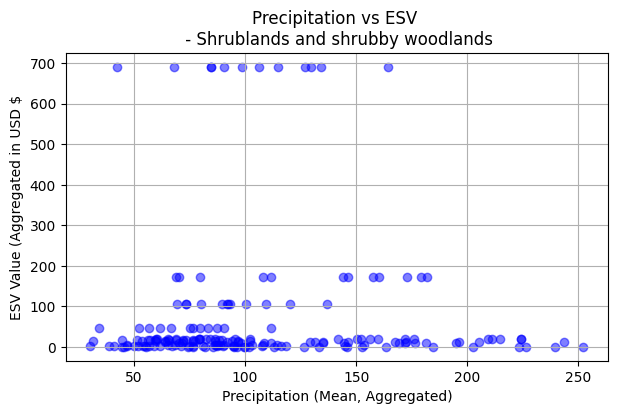

=== Correlation Analysis Results for Shrublands and shrubby woodlands ===
Pearson Correlation: r=0.0059, 95% CI: [-0.1405, 0.1520], p-value: 9.3745e-01
Spearman Correlation: 95% CI: [-0.1286, 0.1489]

Processing: Boreal and montane forests and woodlands


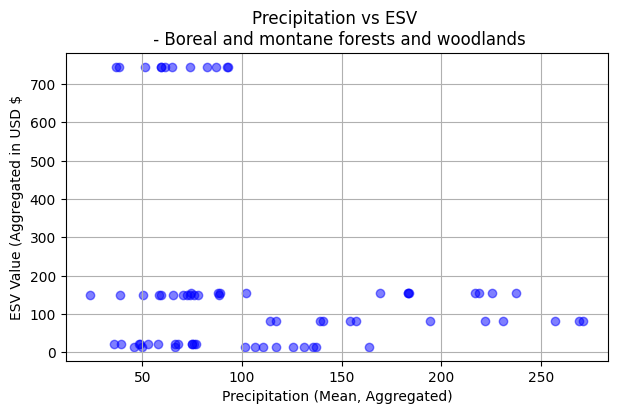

=== Correlation Analysis Results for Boreal and montane forests and woodlands ===
Pearson Correlation: r=-0.2443, 95% CI: [-0.4505, -0.0134], p-value: 3.8594e-02
Spearman Correlation: 95% CI: [-0.2750, 0.1793]


{'Tropical and subtropical forests': {'Pearson Correlation': 0.02918936238284709,
  'Pearson P-value': 0.6292149021914444,
  'Pearson CI (Lower)': -0.08918714980679103,
  'Pearson CI (Upper)': 0.1467527400799086,
  'Spearman CI (Lower)': 0.04063742567617105,
  'Spearman CI (Upper)': 0.2707872100037349},
 'Temperate forests and woodlands': {'Pearson Correlation': 0.16566852640305924,
  'Pearson P-value': 0.008412122486151682,
  'Pearson CI (Lower)': 0.04297547794412777,
  'Pearson CI (Upper)': 0.2834387785160894,
  'Spearman CI (Lower)': 0.01216805901264271,
  'Spearman CI (Upper)': 0.2690320673315846},
 'Intensive land use': {'Pearson Correlation': 0.3066066481976454,
  'Pearson P-value': 0.00018575137499699207,
  'Pearson CI (Lower)': 0.15058298074944113,
  'Pearson CI (Upper)': 0.4477274885663895,
  'Spearman CI (Lower)': 0.20849569505672852,
  'Spearman CI (Upper)': 0.512415603125048},
 'Shrublands and shrubby woodlands': {'Pearson Correlation': 0.005889714931197699,
  'Pearson P-va

In [ ]:
# Version 2: with 95% CI


# Extract the most common biomes for analysis
top_biomes = esv_df['ESVD2.0_Biome'].value_counts().index[:5]  # Selecting top 5 most frequent biomes

# Initialize a dictionary to store results for each biome
biome_results = {}

# Pearson Confidence Interval Function
def pearson_ci(x, y, confidence=0.95):
    r, p_value = stats.pearsonr(x, y)
    n = len(x)

    if n < 4:
        return r, p_value, None, None  # Not enough data for CI

    z = np.arctanh(r)  # Fisher transformation
    se = 1 / np.sqrt(n - 3)  # Standard error
    z_critical = stats.norm.ppf(1 - (1 - confidence) / 2)  # Critical z-score

    z_lower = z - z_critical * se
    z_upper = z + z_critical * se

    r_lower = np.tanh(z_lower)  # Convert back to correlation scale
    r_upper = np.tanh(z_upper)

    return r, p_value, r_lower, r_upper

# Spearman Confidence Interval Function (Bootstrapping)
def spearman_ci(x, y, num_samples=1000, confidence=0.95):
    boot_corrs = []
    n = len(x)

    if n < 4:
        return None, None  # Not enough data for CI

    for _ in range(num_samples):
        sample_idx = np.random.choice(range(n), size=n, replace=True)
        sample_corr, _ = stats.spearmanr(x.iloc[sample_idx], y.iloc[sample_idx])
        boot_corrs.append(sample_corr)

    lower_bound = np.percentile(boot_corrs, (1 - confidence) / 2 * 100)
    upper_bound = np.percentile(boot_corrs, (1 + confidence) / 2 * 100)

    return lower_bound, upper_bound

# Loop through each selected biome to perform separate analysis
for biome in top_biomes:
    print(f"\nProcessing: {biome}")

    # Filter datasets for the current biome
    esv_filtered = esv_df[esv_df['ESVD2.0_Biome'] == biome]

    # Merge with CHIRPS precipitation data based on Continent and Date
    merged_df = pd.merge(
        chirps_df[['Continent', 'date', 'mean_precip']],
        esv_filtered[['Continent', 'date', 'ESV_Value']],
        on=['Continent', 'date'], how='inner'
    ).dropna()

    # Convert date to datetime format
    merged_df['date'] = pd.to_datetime(merged_df['date'])

    # Aggregate data by date
    biome_agg_df = merged_df.groupby('date', as_index=False)[['mean_precip', 'ESV_Value']].mean()

    # Check if there are at least two data points before computing correlation
    if len(biome_agg_df) < 2:
        print(f"Skipping {biome} due to insufficient data for correlation analysis.")
        continue

    # Compute Pearson correlation with confidence intervals
    r, p, r_low, r_high = pearson_ci(biome_agg_df['mean_precip'], biome_agg_df['ESV_Value'])

    # Compute Spearman correlation with confidence intervals
    s_low, s_high = spearman_ci(biome_agg_df['mean_precip'], biome_agg_df['ESV_Value'])

    # Store results in dictionary
    biome_results[biome] = {
        "Pearson Correlation": r,
        "Pearson P-value": p,
        "Pearson CI (Lower)": r_low,
        "Pearson CI (Upper)": r_high,
        "Spearman CI (Lower)": s_low,
        "Spearman CI (Upper)": s_high,
    }

    # Plot Scatter Plot
    plt.figure(figsize=(7,4))
    plt.scatter(biome_agg_df['mean_precip'], biome_agg_df['ESV_Value'], alpha=0.5, color='blue')
    plt.xlabel('Precipitation (Mean, Aggregated)')
    plt.ylabel('ESV Value (Aggregated in USD $')
    plt.title(f'Precipitation vs ESV \n - {biome}')
    plt.grid(True)
    plt.show()

    # Print correlation results with confidence intervals
    print(f"=== Correlation Analysis Results for {biome} ===")
    print(f"Pearson Correlation: r={r:.4f}, 95% CI: [{r_low:.4f}, {r_high:.4f}], p-value: {p:.4e}")
    print(f"Spearman Correlation: 95% CI: [{s_low:.4f}, {s_high:.4f}]")

# Return final results for all selected biomes
biome_results


ii. KNDVI


Processing: Tropical and subtropical forests


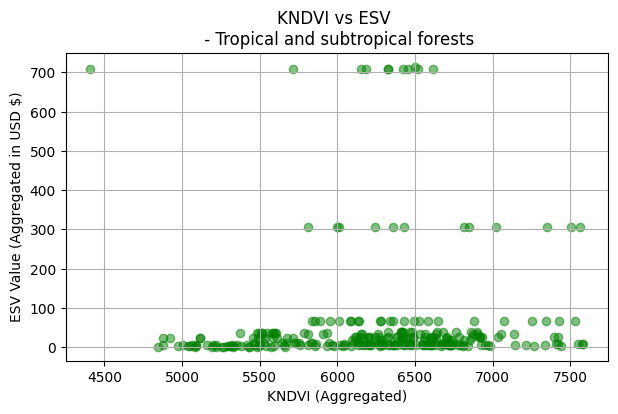

=== Correlation Analysis Results for Tropical and subtropical forests ===
Pearson Correlation: r=0.0568, 95% CI: [-0.0619, 0.1739], p-value: 3.4790e-01
Spearman Correlation: 95% CI: [0.1111, 0.3419]

Processing: Temperate forests and woodlands


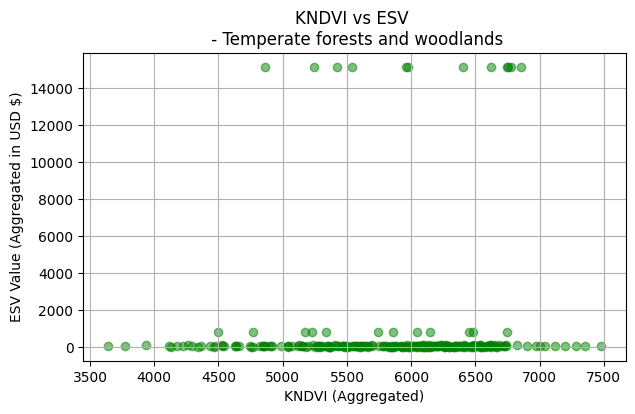

=== Correlation Analysis Results for Temperate forests and woodlands ===
Pearson Correlation: r=0.0803, 95% CI: [-0.0440, 0.2021], p-value: 2.0485e-01
Spearman Correlation: 95% CI: [-0.0056, 0.2337]

Processing: Intensive land use


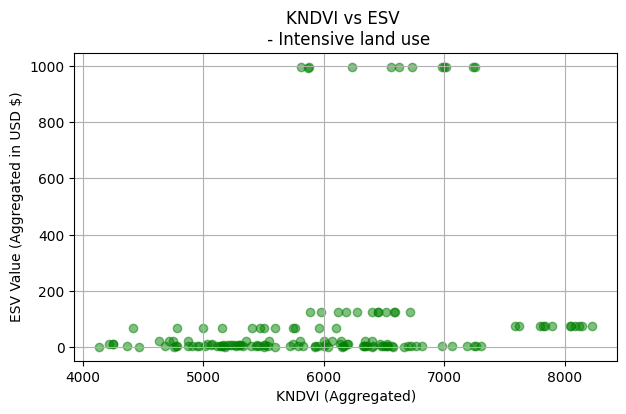

=== Correlation Analysis Results for Intensive land use ===
Pearson Correlation: r=0.2382, 95% CI: [0.0776, 0.3867], p-value: 4.0483e-03
Spearman Correlation: 95% CI: [0.1451, 0.4599]

Processing: Shrublands and shrubby woodlands


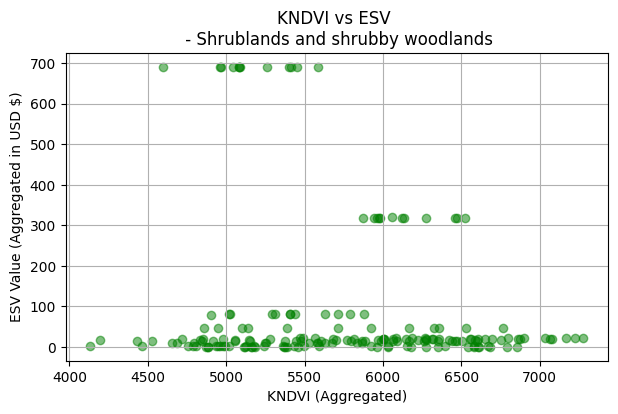

=== Correlation Analysis Results for Shrublands and shrubby woodlands ===
Pearson Correlation: r=-0.1450, 95% CI: [-0.2852, 0.0013], p-value: 5.2104e-02
Spearman Correlation: 95% CI: [-0.0767, 0.2054]

Processing: Boreal and montane forests and woodlands


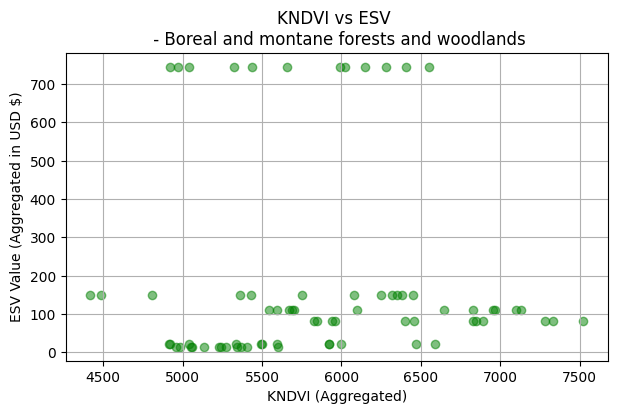

=== Correlation Analysis Results for Boreal and montane forests and woodlands ===
Pearson Correlation: r=-0.0289, 95% CI: [-0.2588, 0.2041], p-value: 8.0956e-01
Spearman Correlation: 95% CI: [-0.0503, 0.4369]


{'Tropical and subtropical forests': {'Pearson Correlation': 0.05681737599987746,
  'Pearson P-value': 0.34789694578031827,
  'Pearson CI (Lower)': -0.06188246454888865,
  'Pearson CI (Upper)': 0.17393240294593315,
  'Spearman CI (Lower)': 0.11114004124696589,
  'Spearman CI (Upper)': 0.3418852273488191},
 'Temperate forests and woodlands': {'Pearson Correlation': 0.0802976071229745,
  'Pearson P-value': 0.20485096071336134,
  'Pearson CI (Lower)': -0.04395863364469013,
  'Pearson CI (Upper)': 0.20210736513253302,
  'Spearman CI (Lower)': -0.005560062541426796,
  'Spearman CI (Upper)': 0.23368970715797296},
 'Intensive land use': {'Pearson Correlation': 0.23815036027780873,
  'Pearson P-value': 0.004048312321355852,
  'Pearson CI (Lower)': 0.07759728839384426,
  'Pearson CI (Upper)': 0.3866635501917383,
  'Spearman CI (Lower)': 0.14511790836020014,
  'Spearman CI (Upper)': 0.459858389255668},
 'Shrublands and shrubby woodlands': {'Pearson Correlation': -0.14501275909998707,
  'Pearson 

In [ ]:
# Correlation for Specific Biome with KNDVI (95% CI)

# Import necessary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Reload the ESV and KNDVI datasets
esv_file = "/content/drive/My Drive/ESV_Data/Filtered_ESV.csv"
kndvi_file = "/content/drive/My Drive/NDVI_Time_Series_With_Country_Continent25.csv"

esv_df = pd.read_csv(esv_file)
kndvi_df = pd.read_csv(kndvi_file)

# Convert date columns to datetime format
esv_df['date'] = pd.to_datetime(esv_df['date']).dt.to_period('M').astype(str)
kndvi_df['date'] = pd.to_datetime(kndvi_df['date']).dt.to_period('M').astype(str)

# Convert relevant columns to numeric
esv_df.rename(columns={'Int$ Per Hectare Per Year': 'ESV_Value'}, inplace=True)
esv_df['ESV_Value'] = pd.to_numeric(esv_df['ESV_Value'], errors='coerce')
kndvi_df.rename(columns={'mean': 'KNDVI_Value'}, inplace=True)
kndvi_df['KNDVI_Value'] = pd.to_numeric(kndvi_df['KNDVI_Value'], errors='coerce')

# Extract the most common biomes for analysis (Top 5 biomes)
top_biomes = esv_df['ESVD2.0_Biome'].value_counts().index[:5]

# Initialize a dictionary to store results for each biome
biome_results = {}

# Pearson Confidence Interval Function
def pearson_ci(x, y, confidence=0.95):
    r, p_value = stats.pearsonr(x, y)
    n = len(x)

    if n < 4:
        return r, p_value, None, None  # Not enough data for CI

    z = np.arctanh(r)  # Fisher transformation
    se = 1 / np.sqrt(n - 3)  # Standard error
    z_critical = stats.norm.ppf(1 - (1 - confidence) / 2)  # Critical z-score

    z_lower = z - z_critical * se
    z_upper = z + z_critical * se

    r_lower = np.tanh(z_lower)  # Convert back to correlation scale
    r_upper = np.tanh(z_upper)

    return r, p_value, r_lower, r_upper

# Spearman Confidence Interval Function (Bootstrapping)
def spearman_ci(x, y, num_samples=1000, confidence=0.95):
    boot_corrs = []
    n = len(x)

    if n < 4:
        return None, None  # Not enough data for CI

    for _ in range(num_samples):
        sample_idx = np.random.choice(range(n), size=n, replace=True)
        sample_corr, _ = stats.spearmanr(x.iloc[sample_idx], y.iloc[sample_idx])
        boot_corrs.append(sample_corr)

    lower_bound = np.percentile(boot_corrs, (1 - confidence) / 2 * 100)
    upper_bound = np.percentile(boot_corrs, (1 + confidence) / 2 * 100)

    return lower_bound, upper_bound

# Loop through each selected biome to perform separate analysis
for biome in top_biomes:
    print(f"\nProcessing: {biome}")

    # Filter datasets for the current biome
    esv_filtered = esv_df[esv_df['ESVD2.0_Biome'] == biome]

    # Merge with KNDVI data based on Continent and Date
    merged_df = pd.merge(
        kndvi_df[['Continent', 'date', 'KNDVI_Value']],
        esv_filtered[['Continent', 'date', 'ESV_Value']],
        on=['Continent', 'date'], how='inner'
    ).dropna()

    # Convert date to datetime format
    merged_df['date'] = pd.to_datetime(merged_df['date'])

    # Aggregate data by date
    biome_agg_df = merged_df.groupby('date', as_index=False)[['KNDVI_Value', 'ESV_Value']].mean()

    # Check if there are at least two data points before computing correlation
    if len(biome_agg_df) < 2:
        print(f"Skipping {biome} due to insufficient data for correlation analysis.")
        continue

    # Compute Pearson correlation with confidence intervals
    r, p, r_low, r_high = pearson_ci(biome_agg_df['KNDVI_Value'], biome_agg_df['ESV_Value'])

    # Compute Spearman correlation with confidence intervals
    s_low, s_high = spearman_ci(biome_agg_df['KNDVI_Value'], biome_agg_df['ESV_Value'])

    # Store results in dictionary
    biome_results[biome] = {
        "Pearson Correlation": r,
        "Pearson P-value": p,
        "Pearson CI (Lower)": r_low,
        "Pearson CI (Upper)": r_high,
        "Spearman CI (Lower)": s_low,
        "Spearman CI (Upper)": s_high,
    }

    # Plot Scatter Plot
    plt.figure(figsize=(7,4))
    plt.scatter(biome_agg_df['KNDVI_Value'], biome_agg_df['ESV_Value'], alpha=0.5, color='green')
    plt.xlabel('KNDVI (Aggregated)')
    plt.ylabel('ESV Value (Aggregated in USD $)')
    plt.title(f'KNDVI vs ESV \n - {biome}')
    plt.grid(True)
    plt.show()

    # Print correlation results with confidence intervals
    print(f"=== Correlation Analysis Results for {biome} ===")
    print(f"Pearson Correlation: r={r:.4f}, 95% CI: [{r_low:.4f}, {r_high:.4f}], p-value: {p:.4e}")
    print(f"Spearman Correlation: 95% CI: [{s_low:.4f}, {s_high:.4f}]")

# Return final results for all selected biomes
biome_results


Prepare to plot a Heatmap for Specific Biome with KNDVI (95% CI)

In [ ]:
# Convert biome names to lowercase and strip spaces
esv_df['ESVD2.0_Biome'] = esv_df['ESVD2.0_Biome'].str.lower().str.strip()

# Print the first few cleaned biome names
print("Cleaned Unique Biomes:\n", esv_df['ESVD2.0_Biome'].unique()[:10])  # Show first 10 unique values


Cleaned Unique Biomes:
 ['temperate forests and woodlands; rivers and lakes; rangelands, natural grasslands and savannas'
 'temperate forests and woodlands; rivers and lakes'
 'temperate forests and woodlands'
 'temperate forests and woodlands; rivers and lakes; rangelands, natural grasslands and savannas; inland wetlands; intensive land use'
 'rivers and lakes; rangelands, natural grasslands and savannas'
 'temperate forests and woodlands; boreal and montane forests and woodlands'
 'marine; coastal systems; inland wetlands; rivers and lakes; temperate forests and woodlands; boreal and montane forests and woodlands; rangelands, natural grasslands and savannas; human made structures'
 'marine; coastal systems; rivers and lakes; tropical and subtropical forests; intensive land use; subterranean'
 'inland wetlands; temperate forests and woodlands'
 'boreal and montane forests and woodlands; temperate forests and woodlands']


In [ ]:
# Define the updated list of biomes ()
selected_biomes = [
    "tropical and subtropical forests",
    "temperate forests and woodlands",
    "intensive land use",  # Fixed this entry
    "shrublands and shrubby woodlands",
    "boreal and montane forests and woodlands"
]

# Apply filtering using partial string matching
esv_filtered = esv_df[esv_df['ESVD2.0_Biome'].apply(lambda x: any(biome in x for biome in selected_biomes))]

# Check if filtering worked
print("Filtered ESV Data Shape:", esv_filtered.shape)
print("First Few Rows of Filtered ESV:\n", esv_filtered.head())


Filtered ESV Data Shape: (32364, 6)
First Few Rows of Filtered ESV:
   Continent  year  month                                      ESVD2.0_Biome  \
0    Europe  2010      1  temperate forests and woodlands; rivers and la...   
1    Europe  2010      2  temperate forests and woodlands; rivers and la...   
2    Europe  2010      3  temperate forests and woodlands; rivers and la...   
3    Europe  2010      4  temperate forests and woodlands; rivers and la...   
4    Europe  2010      5  temperate forests and woodlands; rivers and la...   

   ESV_Value     date  
0   49.40485  2010-01  
1   49.40485  2010-02  
2   49.40485  2010-03  
3   49.40485  2010-04  
4   49.40485  2010-05  


In [ ]:
# Change the Column
# esv_filtered
esv_filtered.rename(columns={"ESV_Value": "Int$ Per Hectare Per Year"}, inplace=True)

<ipython-input-117-5f39978a8b94>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esv_filtered.rename(columns={"ESV_Value": "Int$ Per Hectare Per Year"}, inplace=True)


In [ ]:
# Aggregate ESV values by biome and date
esv_grouped = esv_filtered.groupby(['date', 'ESVD2.0_Biome'])['Int$ Per Hectare Per Year'].mean().unstack()

# Check if aggregation worked
print("ESV Grouped Shape:", esv_grouped.shape)
print("ESV Grouped Columns (Biomes):", esv_grouped.columns)
print("First Few Rows of ESV Grouped:\n", esv_grouped.head())


In [ ]:
# Define a function to simplify biome names
def simplify_biome_name(biome):
    for base_biome in selected_biomes:
        if base_biome in biome:
            return base_biome  # Assign the base category
    return "Other"  # Catch all other biomes

# Apply the function to create a new column with simplified biomes
esv_filtered['Simplified_Biome'] = esv_filtered['ESVD2.0_Biome'].apply(simplify_biome_name)

# Re-aggregate ESV values using the simplified biome categories
esv_grouped_simplified = esv_filtered.groupby(['date', 'Simplified_Biome'])['Int$ Per Hectare Per Year'].mean().unstack()

# Confirm if aggregation worked
print("ESV Grouped (Simplified) Shape:", esv_grouped_simplified.shape)
print("ESV Grouped (Simplified) Columns:", esv_grouped_simplified.columns)
print("First Few Rows of ESV Grouped (Simplified):\n", esv_grouped_simplified.head())


In [ ]:
# Aggregate precipitation by date
precip_grouped = chirps_df.groupby('date')['mean'].mean().rename("Precipitation")

# Merge ESV with precipitation
merged_data = esv_grouped_simplified.merge(precip_grouped, left_index=True, right_index=True, how='inner')

# Merge with KNDVI data
merged_data = merged_data.merge(kndvi_df.set_index('date')[['KNDVI_Value']], left_index=True, right_index=True, how='inner')

# Check if merging worked
print("Merged Data Shape:", merged_data.shape)
print("Merged Data Columns:", merged_data.columns)
print("First Few Rows of Merged Data:\n", merged_data.head())


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = merged_data.corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Precipitation, KNDVI, and Selected Biomes of ESV")
plt.show()


In [ ]:
print(kndvi_df['date'].nunique())  # Number of unique dates


291


<ipython-input-9-40a7dcd80a5c>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esv_filtered['Simplified_Biome'] = esv_filtered['ESVD2.0_Biome'].apply(simplify_biome_name)



=== Correlation Analysis Results ===
Pearson Precipitation vs KNDVI: r=0.3724, 95% CI: [0.2658, 0.4700], p-value: 1.7885e-10
Spearman Precipitation vs KNDVI: 95% CI: [0.1664, 0.3981]
Pearson boreal and montane forests and woodlands vs KNDVI: r=0.1761, 95% CI: [-0.0580, 0.3918], p-value: 1.3900e-01
Spearman boreal and montane forests and woodlands vs KNDVI: 95% CI: [-0.0958, 0.3495]
Pearson intensive land use vs KNDVI: r=-0.0116, 95% CI: [-0.1628, 0.1400], p-value: 8.8104e-01
Spearman intensive land use vs KNDVI: 95% CI: [-0.1185, 0.1799]
Pearson shrublands and shrubby woodlands vs KNDVI: r=0.0181, 95% CI: [-0.1285, 0.1640], p-value: 8.0912e-01
Spearman shrublands and shrubby woodlands vs KNDVI: 95% CI: [-0.0453, 0.2490]
Pearson temperate forests and woodlands vs KNDVI: r=0.0409, 95% CI: [-0.0833, 0.1639], p-value: 5.1847e-01
Spearman temperate forests and woodlands vs KNDVI: 95% CI: [-0.0729, 0.1765]
Pearson tropical and subtropical forests vs KNDVI: r=0.0104, 95% CI: [-0.1080, 0.1286

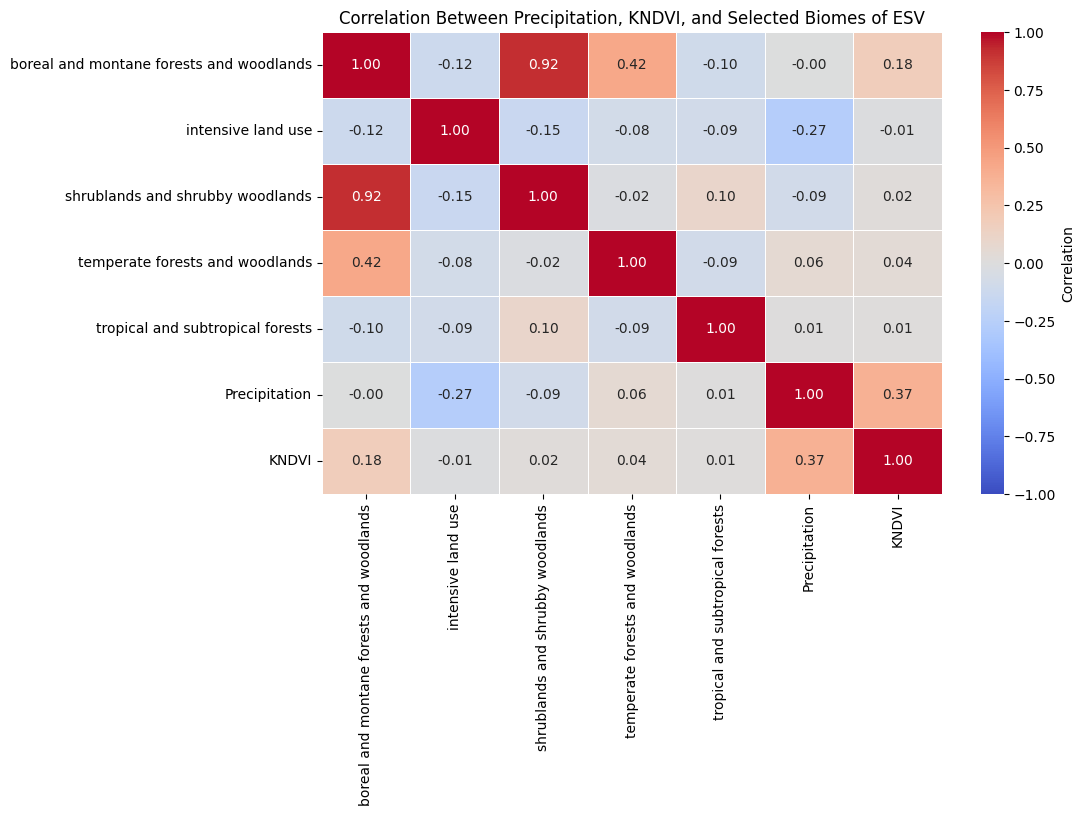

{'Pearson Precipitation vs KNDVI': (0.37240944429966205,
  1.7884737639717565e-10,
  0.26583556299071504,
  0.4699902969852825),
 'Spearman Precipitation vs KNDVI': (0.16643215287600285, 0.39811286651594713),
 'Pearson boreal and montane forests and woodlands vs KNDVI': (0.17607968484677802,
  0.13900041847896946,
  -0.05795289371400432,
  0.39176722351023174),
 'Spearman boreal and montane forests and woodlands vs KNDVI': (-0.09584862274424916,
  0.3495055461931265),
 'Pearson intensive land use vs KNDVI': (-0.011632748607820792,
  0.8810352355484612,
  -0.16275587456659873,
  0.14002366659680576),
 'Spearman intensive land use vs KNDVI': (-0.11850866523628673,
  0.17989957709083973),
 'Pearson shrublands and shrubby woodlands vs KNDVI': (0.018129946111780246,
  0.8091179981696507,
  -0.12847405141506746,
  0.1639584868091092),
 'Spearman shrublands and shrubby woodlands vs KNDVI': (-0.04528899004864454,
  0.24898320542883912),
 'Pearson temperate forests and woodlands vs KNDVI': (0.0

In [ ]:
# This code is vital for the Radar Plot to execute
# Correlation for specific Biome with KNDVI and Precipitation


# Import necessary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Load datasets
chirps_file = "/content/drive/My Drive/CHIRPS_exports/CHIRPS_Monthly_TimeSeries_Fixed.csv"
esv_file = "/content/drive/My Drive/ESV_Data/Filtered_ESV.csv"
kndvi_file = "/content/drive/My Drive/NDVI_Time_Series_With_Country_Continent25.csv"

chirps_df = pd.read_csv(chirps_file)
esv_df = pd.read_csv(esv_file)
kndvi_df = pd.read_csv(kndvi_file)

# Convert date columns to datetime format
chirps_df['date'] = pd.to_datetime(chirps_df['date'], format='%Y-%m')
esv_df['date'] = pd.to_datetime(esv_df['date'], format='%Y-%m-%d')
kndvi_df['date'] = pd.to_datetime(kndvi_df['date'], format='%Y-%m-%d')

# Convert relevant columns to numeric
chirps_df.rename(columns={"mean": "mean_precip"}, inplace=True)
chirps_df['mean_precip'] = pd.to_numeric(chirps_df['mean_precip'], errors='coerce')
esv_df['Int$ Per Hectare Per Year'] = pd.to_numeric(esv_df['Int$ Per Hectare Per Year'], errors='coerce')
kndvi_df['KNDVI'] = pd.to_numeric(kndvi_df['KNDVI'], errors='coerce')

# Standardize biome names (lowercase and strip spaces)
esv_df['ESVD2.0_Biome'] = esv_df['ESVD2.0_Biome'].str.lower().str.strip()

# Define selected biomes (in lowercase)
selected_biomes = [
    "tropical and subtropical forests",
    "temperate forests and woodlands",
    "intensive land use",
    "shrublands and shrubby woodlands",
    "boreal and montane forests and woodlands"
]

# Filter ESV dataset using partial string matching
esv_filtered = esv_df[esv_df['ESVD2.0_Biome'].apply(lambda x: any(biome in x for biome in selected_biomes))]

# Function to assign simplified biome names
def simplify_biome_name(biome):
    for base_biome in selected_biomes:
        if base_biome in biome:
            return base_biome
    return "Other"

# Apply the function to create a new column with simplified biomes
esv_filtered['Simplified_Biome'] = esv_filtered['ESVD2.0_Biome'].apply(simplify_biome_name)

# Aggregate ESV values using the simplified biome categories
esv_grouped_simplified = esv_filtered.groupby(['date', 'Simplified_Biome'])['Int$ Per Hectare Per Year'].mean().unstack()

# Aggregate precipitation by date
precip_grouped = chirps_df.groupby('date')['mean_precip'].mean().rename("Precipitation")

# **Aggregate KNDVI by date to prevent duplicate issues**
kndvi_grouped = kndvi_df.groupby('date')['KNDVI'].mean()

# **Merge ESV with precipitation and KNDVI**
merged_data = esv_grouped_simplified.merge(precip_grouped, left_index=True, right_index=True, how='inner')
merged_data = merged_data.merge(kndvi_grouped, left_index=True, right_index=True, how='inner')

# === Pearson Confidence Interval Function ===
def pearson_ci(x, y, confidence=0.95):
    data = pd.DataFrame({'x': x, 'y': y}).dropna()
    x = data['x']
    y = data['y']

    if len(x) < 4:
        return np.nan, np.nan, np.nan, np.nan

    r, p_value = stats.pearsonr(x, y)
    n = len(x)
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_critical = stats.norm.ppf(1 - (1 - confidence) / 2)
    z_lower = z - z_critical * se
    z_upper = z + z_critical * se
    r_lower = np.tanh(z_lower)
    r_upper = np.tanh(z_upper)

    return r, p_value, r_lower, r_upper

# === Spearman Confidence Interval Function (Bootstrapping) ===
def spearman_ci(x, y, num_samples=1000, confidence=0.95):
    data = pd.DataFrame({'x': x, 'y': y}).dropna()
    x = data['x']
    y = data['y']

    if len(x) < 4:
        return np.nan, np.nan

    boot_corrs = []
    n = len(x)
    for _ in range(num_samples):
        sample_idx = np.random.choice(range(n), size=n, replace=True)
        sample_corr, _ = stats.spearmanr(x.iloc[sample_idx], y.iloc[sample_idx])
        boot_corrs.append(sample_corr)

    lower_bound = np.percentile(boot_corrs, (1 - confidence) / 2 * 100)
    upper_bound = np.percentile(boot_corrs, (1 + confidence) / 2 * 100)

    return lower_bound, upper_bound

# === Compute Pearson and Spearman Correlations ===
correlation_results = {}

for x_col, y_col in [('Precipitation', 'KNDVI')] + [(b, 'KNDVI') for b in esv_grouped_simplified.columns]:
    r, p, r_low, r_high = pearson_ci(merged_data[x_col], merged_data[y_col])
    s_low, s_high = spearman_ci(merged_data[x_col], merged_data[y_col])

    correlation_results[f"Pearson {x_col} vs {y_col}"] = (r, p, r_low, r_high)
    correlation_results[f"Spearman {x_col} vs {y_col}"] = (s_low, s_high)

# === Print correlation results ===
print("\n=== Correlation Analysis Results ===")
for key, value in correlation_results.items():
    if "Pearson" in key:
        if not np.isnan(value[0]):
            print(f"{key}: r={value[0]:.4f}, 95% CI: [{value[2]:.4f}, {value[3]:.4f}], p-value: {value[1]:.4e}")
        else:
            print(f"{key}: Insufficient data for correlation analysis.")
    else:
        if not np.isnan(value[0]):
            print(f"{key}: 95% CI: [{value[0]:.4f}, {value[1]:.4f}]")
        else:
            print(f"{key}: Insufficient data for correlation analysis.")

# === Plot Heatmap of Pearson Correlations ===
correlation_matrix = merged_data.corr()

plt.figure(figsize=(10, 6))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm",
            fmt=".2f", linewidths=0.5,
            cbar_kws={'label': 'Correlation'}, vmin=-1, vmax=1)

plt.title("Correlation Between Precipitation, KNDVI, and Selected Biomes of ESV")
plt.show()

# Return correlation results
correlation_results


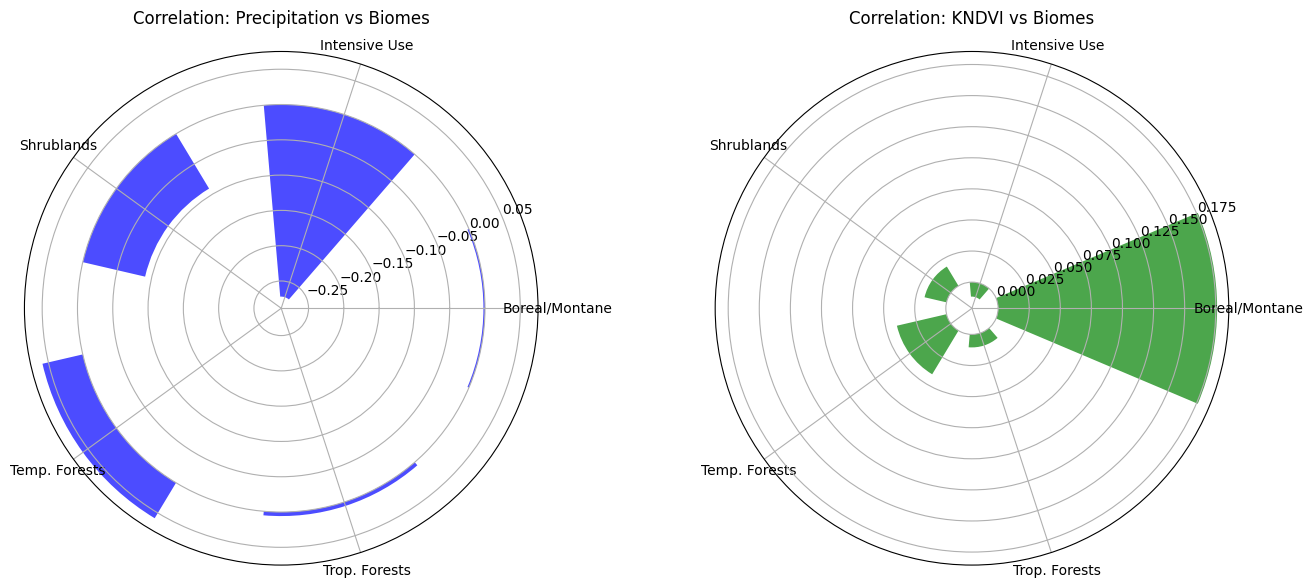

In [ ]:
# Visualise with Radar Chart


import numpy as np
import matplotlib.pyplot as plt

# Define abbreviated labels for biomes
biome_labels = {
    "boreal and montane forests and woodlands": "Boreal/Montane",
    "intensive land use": "Intensive Use",
    "shrublands and shrubby woodlands": "Shrublands",
    "temperate forests and woodlands": "Temp. Forests",
    "tropical and subtropical forests": "Trop. Forests"
}

# Extract biomes present in the correlation matrix
biome_columns = [col for col in correlation_matrix.columns if col in biome_labels]

# Get correlation values
precip_values = correlation_matrix.loc["Precipitation", biome_columns].values  # Precipitation vs Biomes
kndvi_values = correlation_matrix.loc["KNDVI", biome_columns].values  # KNDVI vs Biomes

# Abbreviated labels for plotting
abbreviated_labels = [biome_labels[col] for col in biome_columns]

angles = np.linspace(0, 2 * np.pi, len(biome_columns), endpoint=False)

# Create two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': 'polar'})

# Precipitation vs Biomes
axs[0].bar(angles, precip_values, align='center', alpha=0.7, color='blue')
axs[0].set_xticks(angles)
axs[0].set_xticklabels(abbreviated_labels, fontsize=10)
axs[0].set_title("Correlation: Precipitation vs Biomes", pad=20)

# KNDVI vs Biomes
axs[1].bar(angles, kndvi_values, align='center', alpha=0.7, color='green')
axs[1].set_xticks(angles)
axs[1].set_xticklabels(abbreviated_labels, fontsize=10)
axs[1].set_title("Correlation: KNDVI vs Biomes", pad=20)

# Adjust layout for extra spacing
plt.subplots_adjust(top=0.85)  # Move plots down slightly
plt.tight_layout()
plt.show()
